In [1]:
import gc, argparse, sys, os, errno
%pylab inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
sns.set()
import h5py
import os
from tqdm import tqdm
import scipy
import sklearn
from scipy.stats import pearsonr
import warnings
warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib


/home/chenxupeng/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
import matplotlib.animation as animation
from matplotlib import rc
from IPython.display import HTML, Image
from ipywidgets import interact,Dropdown,IntSlider,FloatRangeSlider, FloatSlider, RadioButtons
rc('animation', html='html5')

In [3]:
cd /home/chenxupeng/projects/connectome/

/home/chenxupeng/projects/connectome


In [9]:
sys.path.append('bin/augment-master/augment/')

In [10]:
from transform import *
from augment import *

In [11]:
# create some example data
image = np.ones((100,500,500), dtype=np.float)
image[:] = 0.5
image[:,:10,:] = 0.75
image[:10,:10,:10] = 1
image[:,::10,:] = 1
image[:,:,::10] = 1

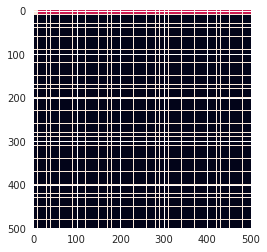

In [12]:
imshow(image[0])

In [13]:
transformation = augment.create_identity_transformation(image.shape)

In [14]:
transformation.shape

(3, 100, 500, 500)

In [23]:
np.unique(transformation,return_counts=True)

(array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
         11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
         22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
         33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,
         44.,  45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,
         55.,  56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,
         66.,  67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,
         77.,  78.,  79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,
         88.,  89.,  90.,  91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,
         99., 100., 101., 102., 103., 104., 105., 106., 107., 108., 109.,
        110., 111., 112., 113., 114., 115., 116., 117., 118., 119., 120.,
        121., 122., 123., 124., 125., 126., 127., 128., 129., 130., 131.,
        132., 133., 134., 135., 136., 137., 138., 139., 140., 141., 142.,
        143., 144., 145., 146., 147., 

In [18]:
np.moveaxis(transformation[:,0,:,:],0,-1).shape

(500, 500, 3)

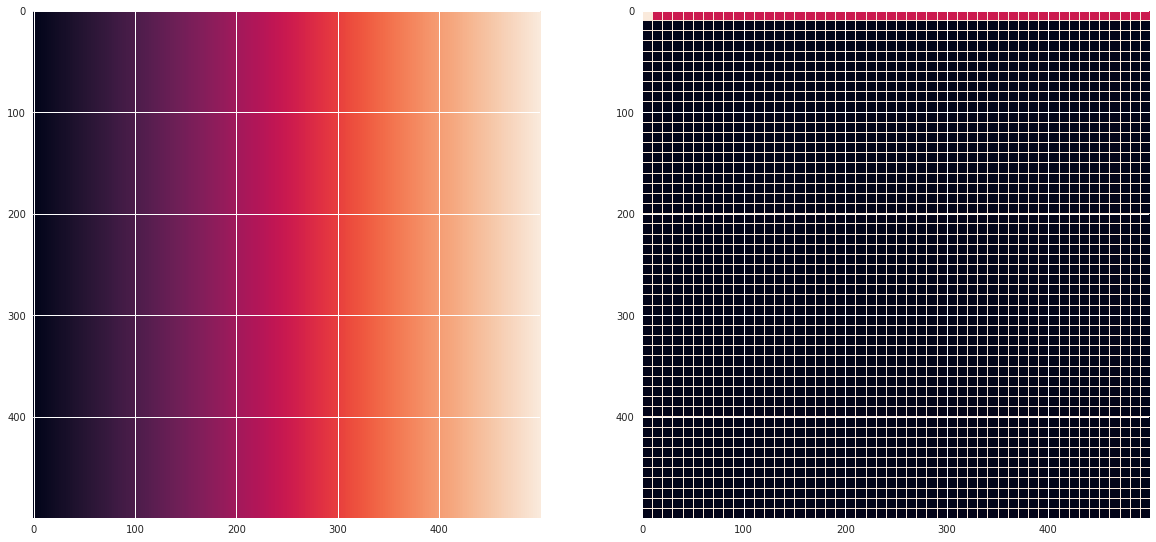

In [21]:
fig,ax=plt.subplots(1,2,figsize=(20,10))
ax[0].imshow(np.moveaxis(transformation[:,0,:,:],0,-1)[:,:,2]) 
ax[1].imshow(image[0])
#np.moveaxis(x,0,-1) move axis from first to last position

In [22]:
augment.create_elastic_transformation(
        image.shape,
        control_point_spacing = 100,
        #num_control_points = [3,10,10],
        jitter_sigma = [0.3, 10, 10]).shape

(3, 100, 500, 500)

#### jitter and rotate function

In [61]:
# jitter in 3D
def jitter_3d(image,mask):
    transformation = augment.create_identity_transformation(image.shape)
    
    #(shape, control_point_spacing = 100, jitter_sigma = 10.0, subsample = 1)
    transformation += augment.create_elastic_transformation(
        image.shape,
        control_point_spacing = 100,
        #num_control_points = [3,10,10],
        jitter_sigma = [0.3, 10, 10])
    imgs = augment.apply_transformation(image, transformation)
    masks = augment.apply_transformation(mask, transformation)
    return imgs,masks

In [62]:
# rotate around z axis
def rotate_z(image,mask):
    transformation = augment.create_identity_transformation(image.shape)
    transformation += augment.create_rotation_transformation(
        image.shape,
        math.pi/4)
    # apply transformation
    imgs = augment.apply_transformation(image, transformation)
    masks = augment.apply_transformation(mask, transformation)
    return imgs,masks

In [28]:
jittedimage = jitter_3d(image)

In [29]:
rotatedimage = rotate_z(image)

In [30]:
jittedimage.shape

(100, 500, 500)

In [31]:
rotatedimage.shape

(100, 500, 500)

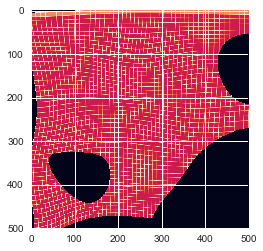

In [33]:
imshow(jittedimage[0])

### test on CREMI

In [76]:
with h5py.File('cremi/gt-syn/syn_A_v2_200.h5') as f:
    syn_A =  f['main'][:]

In [38]:
syn_A.shape

(153, 1842, 1727)

In [42]:
with h5py.File('cremi/images/im_A_v2_200.h5') as f:
    im_A =  f['main'][:]


In [43]:
im_A.shape

(153, 1842, 1727)

In [44]:
with h5py.File('cremi/images/im_A+_v2_200.h5') as f:
    im_A_ =  f['main'][:]


In [45]:
im_A_.shape

(153, 1912, 1741)

In [ ]:
### 注意一定要同步地transform image和mask

In [63]:
jittedimageA,jittedmaskA = jitter_3d(im_A,syn_A)

In [64]:
rotatedimageA,rotatedmaskA = rotate_z(im_A,syn_A)

Text(0.5,1,u'rotated substracted by jitted image')

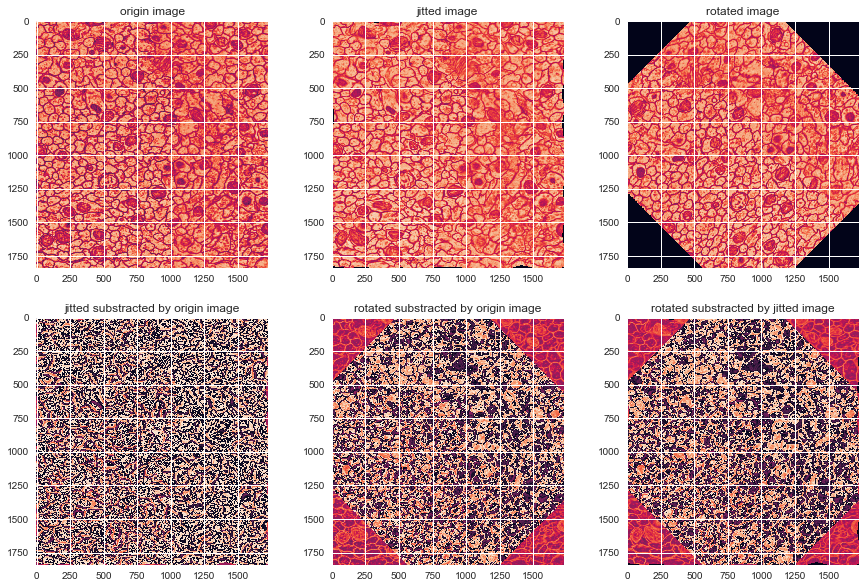

In [71]:
fig,ax=plt.subplots(2,3,figsize=(15,10))
indexsection = 10
ax[0,0].imshow(im_A[indexsection])
ax[0,0].set_title('origin image')
ax[0,1].imshow(jittedimageA[indexsection])
ax[0,1].set_title('jitted image')
ax[0,2].imshow(rotatedimageA[indexsection])
ax[0,2].set_title('rotated image')
ax[1,0].imshow(jittedimageA[indexsection]-im_A[indexsection])
ax[1,0].set_title('jitted substracted by origin image')
ax[1,1].imshow(rotatedimageA[indexsection]-im_A[indexsection])
ax[1,1].set_title('rotated substracted by origin image')
ax[1,2].imshow(rotatedimageA[indexsection]-jittedimageA[indexsection])
ax[1,2].set_title('rotated substracted by jitted image')

#### augment all did rotation and jitter both!

In [80]:
im_A_augall = np.zeros(im_A.shape)
augment_all(im_A,im_A_augall, control_point_spacing = 100, jitter_sigma = 10, subsample = 1, angle = 0)

Allocated identity transformation
Added elastic transformation in 0.634328842163s
Added rotation transformation in 0.269567012787s
augmentation finished in 35.506677866s


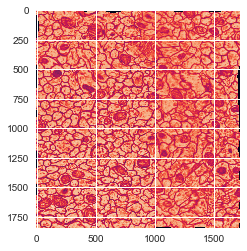

In [84]:
imshow(im_A_augall[10])